In [1]:
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [2]:
# 加载数据
# file_path = "E:\竞赛\服创赛-A08\data\欺诈手段特征集.xlsx"
# data = pd.read_excel(file_path)

file_path = "E:\竞赛\服创赛-A08\data\\analyzed_data_2.csv"
data = pd.read_csv(file_path)

# 展示数据的前几行以及基本信息
data.head(), data.info(), data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RES       16000 non-null  int64  
 1   月就诊天数差    16000 non-null  float64
 2   月就诊医院数差   16000 non-null  float64
 3   月统筹金额差    16000 non-null  float64
 4   月药品金额差    16000 non-null  float64
 5   医院_就诊天数差  16000 non-null  float64
 6   医院_统筹金差   16000 non-null  float64
 7   医院_药品差    16000 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 1000.1 KB


(   RES    月就诊天数差   月就诊医院数差      月统筹金额差       月药品金额差  医院_就诊天数差      医院_统筹金差  \
 0    0  1.333333  0.833333  959.886667  1206.158333  8.666667  2470.413333   
 1    0  1.500000  0.666667  580.301667   665.976667  5.500000  4587.995000   
 2    0  1.833333  0.833333  777.496667   933.531667  8.000000  3995.623333   
 3    0  2.333333  0.166667  972.890000   451.390000  5.500000  5449.010000   
 4    0  0.666667  0.000000  136.135000   145.336667  0.000000     0.000000   
 
         医院_药品差  
 0  3131.986667  
 1  4960.180000  
 2  6023.453333  
 3  2358.410000  
 4     0.000000  ,
 None,
                 RES        月就诊天数差       月就诊医院数差        月统筹金额差        月药品金额差  \
 count  16000.000000  16000.000000  16000.000000  16000.000000  16000.000000   
 mean       0.049563      1.969624      0.363046   1160.144654   1028.518475   
 std        0.217046      1.446184      0.429722   1514.596578   1202.404458   
 min        0.000000      0.000000      0.000000      0.000000      0.000000   
 25%    

In [3]:
# 删除高度相关的特征（>0.9）--可选
# data = data.drop(columns=['月就诊天数_MAX', '月就诊天数_AVG', '月就诊医院数_MAX'])

In [4]:
# 分离特征和目标变量
X = data.drop('RES', axis=1)
y = data['RES']

# 分离类别
data_majority = data[data.RES == 0]
data_minority = data[data.RES == 1]

In [5]:
# 定义一个函数来执行带有不同欠采样比例的交叉验证
def evaluate_downsampling_ratios(X, y, ratios):
    results = {}
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

    for ratio in ratios:
        print(f"\n欠采样比例: {ratio}:1")
        
        for train_index, test_index in skf.split(X, y):
            # 分割数据
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # 分离多数和少数类
            X_train_majority = X_train[y_train == 0]
            X_train_minority = X_train[y_train == 1]

            # 执行欠采样
            majority_sample_size = int(len(X_train_minority) * ratio)
            X_train_majority_downsampled = resample(X_train_majority, 
                                                    replace=False,
                                                    n_samples=majority_sample_size,
                                                    random_state=123)
            y_train_majority_downsampled = y_train.loc[X_train_majority_downsampled.index]

            # 合并数据
            X_train_downsampled = pd.concat([X_train_majority_downsampled, X_train_minority])
            y_train_downsampled = pd.concat([y_train_majority_downsampled, y_train[y_train == 1]])

            # 创建并训练模型
            gbdt = GradientBoostingClassifier(
                max_depth = 5,
                random_state = 42
            )
            gbdt.fit(X_train_downsampled, y_train_downsampled)

            # 预测
            y_pred = gbdt.predict(X_test)

            # 输出分类报告
            print(classification_report(y_test, y_pred))

# 欠采样比例
ratios = [3, 4, 5, 6]

# 执行评估
evaluate_downsampling_ratios(X, y, ratios)


欠采样比例: 3:1
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      3042
           1       0.30      0.47      0.36       158

    accuracy                           0.92      3200
   macro avg       0.63      0.71      0.66      3200
weighted avg       0.94      0.92      0.93      3200

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      3042
           1       0.34      0.46      0.39       158

    accuracy                           0.93      3200
   macro avg       0.66      0.71      0.68      3200
weighted avg       0.94      0.93      0.93      3200

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      3041
           1       0.29      0.48      0.36       159

    accuracy                           0.91      3200
   macro avg       0.63      0.71      0.66      3200
weighted avg       0.94      0.91      0.92      3200

       

In [6]:
# 定义一个额外的函数，用于单独训练和返回比例为4的模型
def get_specific_ratio_model(X, y, specific_ratio):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    final_model = None

    for train_index, test_index in skf.split(X, y):
        # 分割数据
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # 分离多数和少数类
        X_train_majority = X_train[y_train == 0]
        X_train_minority = X_train[y_train == 1]

        # 执行欠采样
        majority_sample_size = int(len(X_train_minority) * specific_ratio)
        X_train_majority_downsampled = resample(X_train_majority, 
                                                replace=False,
                                                n_samples=majority_sample_size,
                                                random_state=123)
        y_train_majority_downsampled = y_train.loc[X_train_majority_downsampled.index]

        # 合并数据
        X_train_downsampled = pd.concat([X_train_majority_downsampled, X_train_minority])
        y_train_downsampled = pd.concat([y_train_majority_downsampled, y_train[y_train == 1]])

        # 创建并训练模型
        gbdt = GradientBoostingClassifier(
            max_depth = 5,
            random_state = 42
        )
        gbdt.fit(X_train_downsampled, y_train_downsampled)

        # 更新最后一个模型
        final_model = gbdt

    return final_model

In [7]:
# 获取比例为n:1的模型(提高比例会略微提高AUC，但不显著)
specific_ratio = 6
gbdt = get_specific_ratio_model(X, y, specific_ratio)

# 输出比例为4的模型
gbdt

GradientBoostingClassifier(max_depth=5, random_state=42)

In [8]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# 设置阈值
threshold = 0.5

# 以概率形式获取预测结果
y_probs = gbdt.predict_proba(X_test)[:, 1] # 获取正类的概率

# 应用阈值
y_pred_thresh = np.where(y_probs > threshold, 1, 0)

# 生成分类报告
classification_report_06 = classification_report(y_test, y_pred_thresh)

print(classification_report_06)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4572
           1       0.53      0.52      0.53       228

    accuracy                           0.96      4800
   macro avg       0.75      0.75      0.75      4800
weighted avg       0.95      0.96      0.96      4800



In [9]:
from sklearn.metrics import roc_auc_score, roc_curve
y_pred_proba = gbdt.predict_proba(X_test)[:, 1]

# 计算AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc}")

AUC: 0.8947761738116069


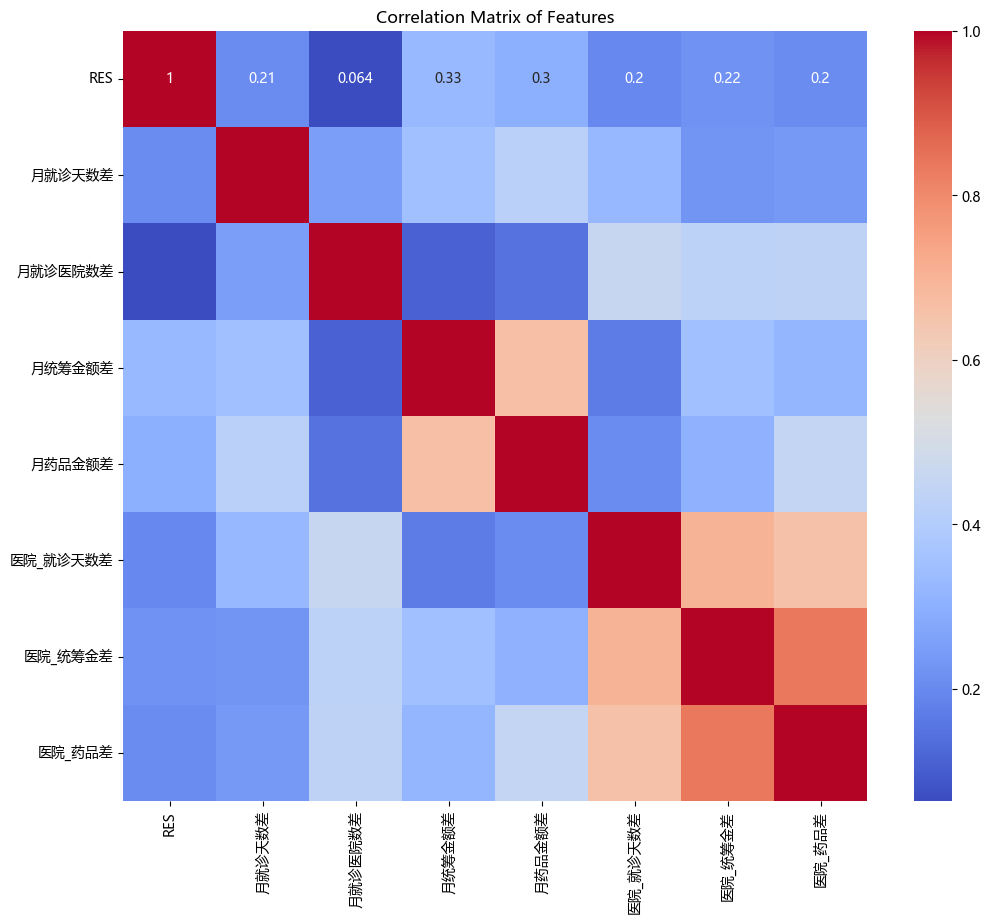

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_columns",100)
pd.set_option('display.max_rows',100)

from pylab import mpl 
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 为了显示负号正常


correlation_matrix = data.corr()


plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

In [11]:
# 获取特征重要性
feature_importances = gbdt.feature_importances_

# 排序特征重要性
sorted_idx = np.argsort(feature_importances)[::-1]

# 取出前二十个重要特征
feature_importances = np.array(X.columns)[sorted_idx][:10]

feature_importances

array(['月统筹金额差', '月药品金额差', '医院_就诊天数差', '医院_统筹金差', '月就诊天数差', '医院_药品差',
       '月就诊医院数差'], dtype=object)